In [ ]:
# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=0
# %env XLA_PYTHON_CLIENT_PREALLOCATE=false

In [ ]:
!pip install flax -q

In [ ]:
import json
import os
from collections import defaultdict
from functools import partial
from random import sample as sample_no_duplicates

import cv2
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from flax import linen as nn
from flax import optim, serialization
from jax import grad, jit, random, value_and_grad, vmap
from jax.config import config
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
config.enable_omnistaging()

# Generate key which is used to generate random numbers
rng = random.PRNGKey(0)

In [ ]:
from enum import Enum
class DatasetEnum(Enum):
    NERF = "nerf_example"
    TINY = "tiny_nerf"

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
cfg={
    "gpu_id": 0,
    "lr": 0.001,
    "num_epochs": 200,
    "comments": "Final model + use 3D for view dir",
    "near_clip": 2.0,
    "far_clip": 6.0,
    "ray_sample": 32,
    "fine_ray_sample": 64,
    "encode_num": 10,
    "encode_num_view": 4,
    "layer_num": 6,
    "hidden_ch": 128,
    "dataset_type": "NERF",  # "NERF", "TINY"
    "half_res": True,
    "testset_num": 32,
    "workers": 2,
}
cfg = AttrDict(cfg)


# import wandb
# wandb.init(
#     project="nerf_practice",
#     config=cfg,
# )
# cfg = wandb.config
cfg

{'comments': 'Final model + use 3D for view dir',
 'dataset_type': 'NERF',
 'encode_num': 10,
 'encode_num_view': 4,
 'far_clip': 6.0,
 'fine_ray_sample': 64,
 'gpu_id': 0,
 'half_res': True,
 'hidden_ch': 128,
 'layer_num': 6,
 'lr': 0.001,
 'near_clip': 2.0,
 'num_epochs': 200,
 'ray_sample': 32,
 'testset_num': 32,
 'workers': 4}

In [ ]:
ch_dim = 3
view_dim = 3
if not os.path.exists('./results'):
    os.mkdir('./results')
if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')

In [ ]:
DATASET = getattr(DatasetEnum, cfg.dataset_type)

In [ ]:
DATASET

<DatasetEnum.NERF: 'nerf_example'>

In [ ]:
from os.path import join
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


class TinyNeRFDataset(Dataset):
    def __init__(self, npy_filename, split_type="train", transform=None):
        # Load data
        data = np.load(npy_filename)
        self.samples = []
        for img, pose in zip(data["images"], data["poses"]):
            # Adjust poses so that camera front is z+
            T = np.eye(3)
            T[1, 1] = -1
            T[2, 2] = -1
            pose[:3, :3] = pose[:3, :3].dot(T)
            self.samples.append((img, pose))
        self.focal = data["focal"]

        test_idx = 100
        if split_type == "train":
            self.samples = self.samples[:test_idx]
        else:
            self.samples = self.samples[test_idx:]

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, pose = self.samples[idx]
        sample = {"img": img, "pose": pose}
        if self.transform:
            sample = self.transform(sample)
        sample["focal"] = self.focal
        return sample


class NeRFDataset(Dataset):
    object_names = [
        "chair",
        "drums",
        "ficus",
        "hotdog",
        "lego",
        "materials",
        "mic",
        "ship",
    ]

    def __init__(self, root_dir, split_type="train", transform=None, half_res=False):
        # Load data
        self.root_dir = root_dir
        self.half_res = half_res
        json_filename = join(self.root_dir, f"transforms_{split_type}.json")
        with open(json_filename) as f:
            json_data = json.load(f)

        self.samples = []
        for frame in json_data["frames"]:
            img_fname = join(self.root_dir, frame["file_path"] + ".png")

            pose = np.array(frame["transform_matrix"])
            # Adjust poses so that camera front is z+
            T = np.eye(3)
            T[1, 1] = -1
            T[2, 2] = -1
            pose[:3, :3] = pose[:3, :3].dot(T)
            self.samples.append((img_fname, pose))

        # focal length
        img = self.load_image(img_fname)
        h, w = img.shape[:2]
        camera_angle_x = float(json_data["camera_angle_x"])
        self.focal = 0.5 * w / np.tan(0.5 * camera_angle_x)

        self.transform = transform

    def load_image(self, img_fname):
        img = cv2.imread(img_fname, cv2.IMREAD_UNCHANGED)
        # Downsample
        if self.half_res:
            img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
        img = img.astype(np.float32) / 255.0

        if img.shape[2] == 4:
            # Add arbitrary background color for image with alpha
            bkg = np.array([1.0, 1.0, 1.0], dtype=np.float32)
            img_rgb = img[..., :3]
            img_alpha = img[..., 3:]
            img = img_rgb*img_alpha + bkg*(1.-img_alpha) 
        # BGR to RGB
        img = np.array(img[...,::-1])
        return img

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_fname, pose = self.samples[idx]
        img = self.load_image(img_fname)
        sample = {"img": img, "pose": pose}
        if self.transform:
            sample = self.transform(sample)
        sample["focal"] = self.focal
        return sample

# Data visualization

In [ ]:
if not os.path.exists('data/'):
    # Load dataset using official script
    !wget https://raw.githubusercontent.com/bmild/nerf/master/download_example_data.sh
    !bash download_example_data.sh

--2021-03-11 05:43:31--  https://raw.githubusercontent.com/bmild/nerf/master/download_example_data.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233 [text/plain]
Saving to: ‘download_example_data.sh’

download_example_da 100%[===================>]     233  --.-KB/s    in 0s      

2021-03-11 05:43:31 (18.5 MB/s) - ‘download_example_data.sh’ saved [233/233]

--2021-03-11 05:43:32--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M

In [ ]:
from torch.utils.data import Subset
print("Dataset type:", DATASET)
if DATASET == DatasetEnum.NERF:
    root_dir = './data/nerf_synthetic/lego'
    if not os.path.split(root_dir)[-1] in NeRFDataset.object_names:
        print("The object might not be included")
    trainset = NeRFDataset(root_dir, split_type="train", half_res=cfg.half_res)
    all_testset = NeRFDataset(root_dir, split_type="test", half_res=cfg.half_res)
elif DATASET == DatasetEnum.TINY:
    tiny_data = "tiny_nerf_data.npz"
    trainset = TinyNeRFDataset(tiny_data, split_type="train")
    all_testset = TinyNeRFDataset(tiny_data, split_type="test")
    cfg.testset_num = 0
else:
    raise Exception("Unknown dataset")

if cfg.testset_num > 0:
    testset = Subset(all_testset, range(cfg.testset_num))
else:
    testset = all_testset
print(f"Dataset size:", len(trainset), len(testset))

Dataset type: DatasetEnum.NERF
Dataset size: 100 32


In [ ]:
def drawAxis(T=np.eye(4), scale=0.3, colors=["r", "g", "b"]):
    tvec = T[:3, 3]
    R = T[:3, :3]
    start = tvec.flatten()[np.newaxis].repeat(3, axis=0)
    end = start + scale * R.T
    for s, e, c in zip(start, end, colors):
        ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], c=c)


%matplotlib inline

In [ ]:
# Load data
sample = trainset[0]
img = sample['img']
pose = sample['pose']
focal = sample['focal']
print("focal:", focal)

camera_bnd = np.array([it['pose'][:3, 3] for it in trainset])
print("Camera position range")
print(camera_bnd.max())
print(camera_bnd.min())
camera_bnd_max = max(abs(camera_bnd.max()), abs(camera_bnd.min()))
print(camera_bnd_max)

focal: 555.5555155968841
Camera position range
4.0305280685424805
-3.9398677349090576
4.0305280685424805


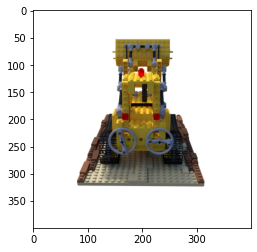

In [ ]:
plt.imshow(img)

In [ ]:
def collate_fn(batch):
    sample = {key: [] for key in batch[0].keys()}
    for it in batch:
        for key, val in it.items():
            sample[key].append(val)
    sample = {key: np.stack(val) for key, val in sample.items()}
    return sample


In [ ]:
# Get data from batch
batch = iter(DataLoader(trainset, batch_size=32, shuffle=False, collate_fn=collate_fn)).next()
imgs = batch["img"]
poses = batch["pose"]

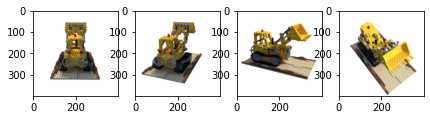

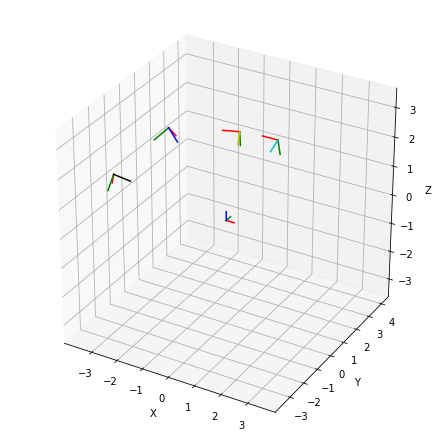

In [ ]:
idx = 0
fig, ax = plt.subplots(1, 4, figsize=(7, 4))
for i in range(4):
    ax[i].imshow(imgs[idx + i])

# 3D Plot
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
# ax.axis('off')
c = ["c", "y", "k", "b"]

for i in range(4):
    colors = ["r", "g", c[i]]
    drawAxis(poses[idx + i], 0.6, colors)

# Origin
drawAxis()

# adjust scale
scale = 7
start = np.zeros((3, 3)) - scale / 2
end = start + scale * np.eye(3)
for s, e in zip(start, end):
    ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], c="none")

## Camera pose generation

In [ ]:
def spherical_to_xyz(r, theta, phi):
    assert theta.shape == phi.shape == r.shape
    x = r * jnp.sin(theta) * jnp.cos(phi)
    y = r * jnp.sin(theta) * jnp.sin(phi)
    z = r * jnp.cos(theta)
    return jnp.stack([x, y, z], axis=-1)


def xyz_to_spherical(pts):
    x = pts[..., 0]
    y = pts[..., 1]
    z = pts[..., 2]

    len_xy = jnp.hypot(x, y)
    r = jnp.hypot(z, len_xy)
    theta = jnp.arctan2(z, len_xy)
    phi = jnp.arctan2(y, x)
    return r, theta, phi


In [ ]:
# Generate camera pose
def get_camera_poses(
    r, theta, phi, lookat=np.array([0, 0, 0.5]), up=np.array([0, 0, 1])
):
    # Camera position in world coord
    cam_pts = spherical_to_xyz(r, theta, phi)
    # Camera orientation
    zaxis = lookat - cam_pts
    zaxis /= np.linalg.norm(zaxis, axis=-1, keepdims=True)
    xaxis = np.cross(zaxis, up)
    xaxis /= np.linalg.norm(xaxis, axis=-1, keepdims=True)
    yaxis = np.cross(zaxis, xaxis)

    R = np.stack([xaxis, yaxis, zaxis], axis=-1)

    # Transform matrix camera coord to world coord
    T_wc = np.array([np.eye(4) for _ in range(cam_pts.shape[0])])
    T_wc[..., :3, :3] = R
    T_wc[..., :3, 3] = cam_pts
    return T_wc

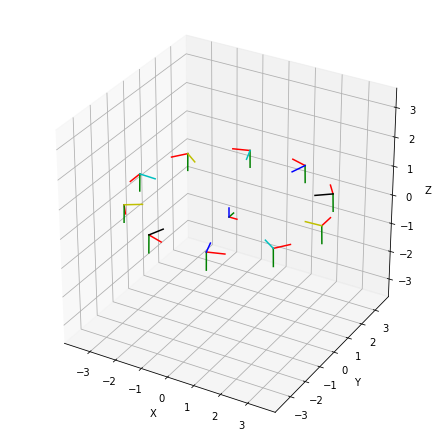

In [ ]:
# r = np.array()
pose_num = 10
r = np.full((pose_num), 3.5)
theta = np.full((pose_num), np.deg2rad(80))
phi = np.linspace(-np.pi, np.pi, pose_num, endpoint=False)
cam_pts = spherical_to_xyz(r, theta, phi)

cam_poses = get_camera_poses(r, theta, phi)

# 3D Plot
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
# ax.axis('off')
c = ["c", "y", "k", "b"]

for i, pose in enumerate(cam_poses):
    colors = ["r", "g", c[i % len(c)]]
    drawAxis(pose, 0.6, colors)

# Origin
drawAxis()

# ax.scatter(pts[...,0], pts[...,1], pts[...,2])

# adjust scale
scale = 7
start = np.zeros((3, 3)) - scale / 2
end = start + scale * np.eye(3)
for s, e in zip(start, end):
    ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], c="none")

# Setting

In [ ]:
height, width, ch = imgs.shape[1:]
cx = width / 2
cy = height / 2
print(f"image height:{height}, width:{width}, f:{focal:.2f}, cx:{cx:.2f}, cy:{cy:.2f}")

# ray direction from cam
x_grid = np.arange(width) - cx + 0.5
y_grid = np.arange(height) - cy + 0.5
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
ray_cam = np.stack([x_grid, y_grid, np.full_like(x_grid, focal)], axis=-1)

# TODO divided by norm or z
ray_cam /= np.linalg.norm(ray_cam, axis=-1, keepdims=True)
ray_tmp = ray_cam[::10, ::10]  # For debug

image height:400, width:400, f:555.56, cx:200.00, cy:200.00


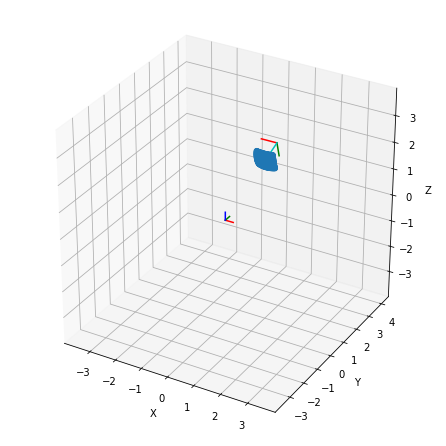

In [ ]:
# 3D Plot
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
# ax.axis('off')
c = ["c", "y", "k", "b"]

i = 0
pose = poses[idx + i]
colors = ["r", "g", c[i]]
drawAxis(pose, 0.6, colors)

# Camera optical center
t = pose[:3, 3]
# Cam coord to world coord rotation
R = pose[:3, :3]

ray_world = ray_tmp.dot(R.T) + t
ray_world = ray_world.reshape(-1, 3)
ax.scatter(ray_world[:, 0], ray_world[:, 1], ray_world[:, 2])

# Origin
drawAxis()

# adjust scale
scale = 7
start = np.zeros((3, 3)) - scale / 2
end = start + scale * np.eye(3)
for s, e in zip(start, end):
    ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], c="none")

In [ ]:
%matplotlib inline

# NeRF Model
## Generate model params

In [ ]:
def encode_variables(x, encode_num):
    # No positional encoding
    if encode_num == 0:
        return x
    # Positional encoding
    frequency_bands = 2.0 ** jnp.linspace(0.0, encode_num - 1, encode_num)
    encoded_grid = []
    for freq in frequency_bands:
        for func in [jnp.sin, jnp.cos]:
            encoded_grid.append(func(jnp.pi * x * freq))
    encoded_grid = jnp.concatenate(encoded_grid, axis=-1)
    return encoded_grid

In [ ]:
from typing import List, Tuple


class NeRF(nn.Module):
    layer_num: int
    hidden_ch: int
    encode_num: int
    encode_num_view: int
    skips: Tuple[int] = (4,)

    @nn.compact
    def __call__(self, x):
        # Encode input
        xyz = x[:3]
        view = x[3:]
        xyz = encode_variables(xyz, self.encode_num)
        view = encode_variables(view, self.encode_num_view)

        # fc
        x = xyz
        for i in range(self.layer_num):
            if i in self.skips:
                x = jnp.concatenate([xyz, x])
            x = nn.Dense(self.hidden_ch, name=f"fc{i}")(x)
            x = jax.nn.relu(x)

        # sigma
        sigma_out = nn.Dense(1, name=f"sigma_fc")(x)
        sigma = jax.nn.relu(sigma_out)

        # rgb
        bottleneck = nn.Dense(self.hidden_ch, name="rgb_fc0")(x)
        x = jnp.concatenate([view, bottleneck])
        x = nn.Dense(self.hidden_ch // 2, name=f"rgb_fc1")(x)
        x = jax.nn.relu(x)
        x = nn.Dense(3, name=f"rgb_fc2")(x)
        rgb = jax.nn.sigmoid(x)

        return sigma, rgb

In [ ]:
def model():
    global cfg
    return NeRF(
        layer_num=cfg.layer_num,
        hidden_ch=cfg.hidden_ch,
        encode_num=cfg.encode_num,
        encode_num_view=cfg.encode_num_view,
    )

In [ ]:
x = random.normal(rng, (ch_dim + view_dim,))

In [ ]:
rng, k1, k2 = random.split(rng, num=3)
params = {}
params['coarse'] = model().init(k1, x)
params['fine'] = model().init(k2, x)
# out = model().apply(params, x)

In [ ]:
# jax.tree_map(lambda x: x.shape, params)

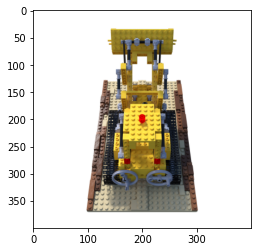

In [ ]:
test_sample = testset[0]
test_img = test_sample['img']
test_pose = test_sample['pose']
plt.imshow(test_img)

In [ ]:
print("train images number:", len(trainset))
print("test images number:", len(testset))
trainloader = DataLoader(
    trainset, batch_size=1, shuffle=True, collate_fn=collate_fn, num_workers=cfg.workers
)
testloader = DataLoader(
    testset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=cfg.workers
)

# pixel ray direction in cam coord
ray_dir_cam = jnp.asarray(ray_cam)
ray_dist = jnp.linspace(cfg.near_clip, cfg.far_clip, cfg.ray_sample)

train images number: 100
test images number: 32


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def prediction(params, x):
    sigma, rgb = model().apply(params, x)
    return sigma, rgb

In [ ]:
x = jnp.ones((ch_dim + view_dim, ))
sigma, rgb = prediction(params["coarse"], x)

In [ ]:
# Sample points along one ray
def _sample_points(ray_dir, t, ray_dist, camera_bnd=6.0):
    # Sample points
    pts = ray_dist[..., None] * ray_dir + t
    
    # Normalize for positional encoder
    pts = pts/camera_bnd
        
    # With direction
    use_theta_phi = False
    if(use_theta_phi):
        # With direction
        r, theta, phi = xyz_to_spherical(ray_dir)

        theta = theta/jnp.pi*2
        phi = phi/jnp.pi

        pts = jnp.concatenate(
            [pts, jnp.full_like(pts[:, :1], theta), jnp.full_like(pts[:, :1], phi)], axis=-1
        )
    else:
        pts = jnp.concatenate([pts, ray_dir[None].repeat(pts.shape[0], 0)], axis=-1)

    # Distance
    dists = ray_dist[1:] - ray_dist[:-1]
    dists = jnp.pad(dists, (0, 1), 'constant', constant_values=(1e10))

    return pts, dists

sample_points = partial(_sample_points, camera_bnd=camera_bnd_max)

def integrate_color(sigma, rgb, dists, bkg = jnp.array([1.0, 1.0, 1.0])):
    transparency = jnp.exp(-sigma.squeeze() * dists)
    alpha = 1 - transparency
    # cumprod_exclusive
    T = jnp.cumprod(transparency)[:-1]
    T = jnp.pad(T, (1, 0), 'constant', constant_values=1)

    # accumulate
    weights = alpha[..., None]*T[..., None]
    colors = rgb*weights
    # Add background color
    colors = colors.sum(axis=0) + bkg * (1.0 - weights.sum())

    return colors, weights

In [ ]:
# prediction along a ray
ray_prediction = vmap(prediction, in_axes=(None, 0))

def render_ray(params, ray_dir, t, ray_dist):
    pts, dists = sample_points(ray_dir, t, ray_dist)
    sigma, rgb = ray_prediction(params, pts)
    colors, weights = integrate_color(sigma, rgb, dists)
    return colors, weights

# Render multiple rays
render_pixels = vmap(render_ray, in_axes=(None, 0, None, None))



In [ ]:
def sample_pdf(weights, sample_num):
    # Calculate pdf and cdf
    weights = weights + 1e-5
    pdf = weights/weights.sum()
    cdf = jnp.cumsum(pdf)

    # linspace(0, 1) without start or end points
    start = 1/(sample_num+1)
    end = 1 - start
    uniform_prob = jnp.linspace(start, end, sample_num)

    # TODO check out of range?
    right_idx = jnp.searchsorted(cdf, uniform_prob, side='right')
    left_idx = right_idx - 1

    # Linear interpolation
    right_factor = (uniform_prob - cdf[left_idx]) / (cdf[right_idx] - cdf[left_idx])
    left_factor = 1.0 - right_factor
    
    return left_idx, left_factor


def render_ray_fine(params, weights, ray_dir, fine_ray_sample, t, ray_dist):
    # Importance sampling
    l_idx, l_factor = sample_pdf(weights, fine_ray_sample)
    fine_ray_dist = l_factor * ray_dist[l_idx] + (1 - l_factor) * ray_dist[l_idx + 1]
    fine_ray_dist = jax.lax.stop_gradient(fine_ray_dist)
    pts, dists = sample_points(ray_dir, t, fine_ray_dist)

    # Color
    sigma, rgb = ray_prediction(params, pts)
    colors, weights = integrate_color(sigma, rgb, dists)
    return colors, weights

render_pixels_fine = vmap(render_ray_fine, in_axes=(None, 0, 0, None, None, None))

# fine_colors, _ = render_pixels_fine(params, weights, batch_dirs, fine_ray_sample, t, ray_dist)

In [ ]:
@partial(jit, static_argnums=2)
def render_pixels_coarse_fine(params, batch_dirs, fine_ray_sample, t, ray_dist):
    # Coarse sampling
    coarse_colors, weights = render_pixels(params['coarse'], batch_dirs, t, ray_dist)
    # Fine sampling
    fine_colors, _ = render_pixels_fine(
        params['fine'], weights, batch_dirs, fine_ray_sample, t, ray_dist
    )
    return fine_colors, coarse_colors

In [ ]:
def loss_fn(params, batch_dirs, batch_pixels, t, ray_dist, fine_ray_sample):
    # Coarse and fine sampling
    fine_colors, coarse_colors = render_pixels_coarse_fine(
        params, batch_dirs, fine_ray_sample, t, ray_dist
    )
    
    # Calculate loss
    coarse_loss = jnp.mean((batch_pixels - coarse_colors) ** 2)
    fine_loss = jnp.mean((batch_pixels - fine_colors) ** 2)
    total_loss = coarse_loss + fine_loss

    return total_loss


In [ ]:
# when you use @jit here, it causes out of gpu memory
# I guess it's because @jit unroll for loop and try to execute once.
# Just use @jit for core function, e.g., render_pixels_coarse_fine
def render_image(params, pose, ray_dir_cam, fine_ray_sample):
    # Camera optical center
    t = pose[:3, 3]
    # Cam coord to world coord rotation
    R = pose[:3, :3]
    # ray direction in world coord
    ray_dir_world = ray_dir_cam.dot(R.T)
    flatten_ray_dir_world = ray_dir_world.reshape(-1, 3)

    coarse_colors = []
    fine_colors = []
    batch_ray_num = 4096
    for pix_idx in range(0, len(flatten_ray_dir_world), batch_ray_num):
        batch_dirs = flatten_ray_dir_world[pix_idx : pix_idx + batch_ray_num]
        # Coarse and fine sampling
        fine, coarse = render_pixels_coarse_fine(
            params, batch_dirs, fine_ray_sample, t, ray_dist
        )
        coarse_colors.append(coarse)
        fine_colors.append(fine)

    # Convert colors into 2d image
    coarse_img = jnp.concatenate(coarse_colors).reshape(ray_dir_cam.shape)
    coarse_img = jnp.clip(coarse_img, a_min=0.0, a_max=1.0)
    fine_img = jnp.concatenate(fine_colors).reshape(ray_dir_cam.shape)
    fine_img = jnp.clip(fine_img, a_min=0.0, a_max=1.0)
    return fine_img, coarse_img


In [ ]:
# Optimizer
optimizer_def = optim.Adam(learning_rate=cfg.lr)
optimizer = optimizer_def.create(params)

# LR scheduler
def create_exponential_lr(initial_lr, decay_steps, decay_rate):
    def learning_rate_fn(step):
        lr = initial_lr*decay_rate**(step/decay_steps)
        return lr
    return learning_rate_fn

# Final learning rate is cfg.lr*0.01
learning_rate_fn = create_exponential_lr(cfg.lr, len(trainloader) * cfg.num_epochs / 2, 0.1)


In [ ]:
from functools import partial


def _optim_step(
    optimizer, batch_dirs, batch_pixels, t, ray_dist, fine_ray_sample, learning_rate_fn
):
    loss_values, grads = value_and_grad(loss_fn)(
        optimizer.target, batch_dirs, batch_pixels, t, ray_dist, fine_ray_sample
    )
    lr = learning_rate_fn(optimizer.state.step)
    optimizer = optimizer.apply_gradient(grads, learning_rate=lr)
    return loss_values, optimizer


# Make fine_ray_sample and learning_rate_fun static args
optim_step = jit(
    partial(
        _optim_step,
        fine_ray_sample=cfg.fine_ray_sample,
        learning_rate_fn=learning_rate_fn,
    )
)

In [ ]:
from skimage.metrics import structural_similarity


def calculate_error_metrics(gt, pred):
    gt = np.array(gt)
    pred = np.array(pred)
    mse = np.mean((gt - pred) ** 2)
    psnr = -10 * np.log(mse) / np.log(10)
    # compatible with tf.image.ssim
    ssim = structural_similarity(
        gt,
        pred,
        multichannel=True,
        data_range=1.0,
        win_size=11,
        K1=0.01,
        K2=0.03,
        sigma=1.5,
    )
    return {"psnr": psnr, "ssim": ssim}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch:0, total_loss:13.86128930002451



{
 "test_ave_psnr": 13.269513939400834,
 "test_ave_ssim": 0.34461414778193405
}


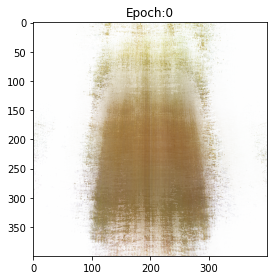

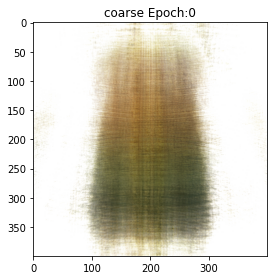

save model: checkpoints/nerf_jax_0.pkl



Epoch:1, total_loss:5.485691394656897


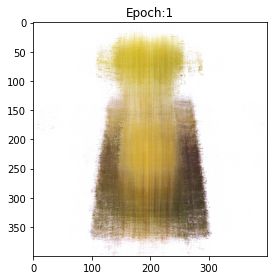

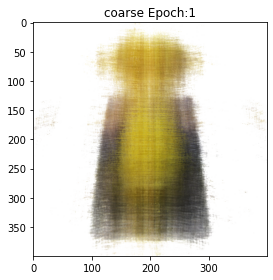


Epoch:2, total_loss:3.796722339466214


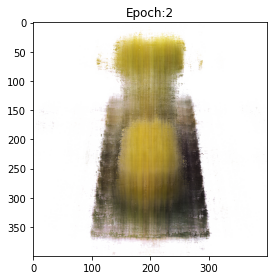

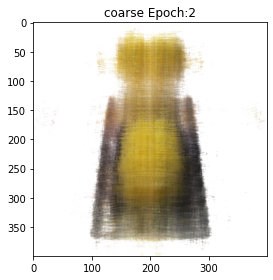

In [ ]:
batch_ray_num = 4096
interval_test_metrics = 100
interval_save_model = 100
interval_visualize_image = 10
until_visualize_image = 5

for epoch in range(cfg.num_epochs):
    total_loss = 0
    cnt = 0
    pbar = tqdm(trainloader, total=len(trainloader), desc=f"[Train] Epoch:{epoch}")
    for batch in pbar:
        img = batch["img"][0]
        pose = batch["pose"][0]

        # Camera optical center
        t = pose[:3, 3]
        # Cam coord to world coord rotation
        R = pose[:3, :3]

        # ray direction in world coord
        ray_dir_world = ray_dir_cam.dot(R.T)
        flatten_ray_dir_world = ray_dir_world.reshape(-1, 3)
        flatten_image = img.reshape(-1, 3)

        # Batch ray select index
        HxW = flatten_ray_dir_world.shape[0]
        batch_idx = np.array(sample_no_duplicates(range(HxW), batch_ray_num))

        # Forward
        batch_dirs = flatten_ray_dir_world[batch_idx]
        batch_pixels = flatten_image[batch_idx]
        loss_vals, optimizer = optim_step(
            optimizer, batch_dirs, batch_pixels, t, ray_dist
        )
        loss_vals = float(loss_vals)  # jax array to float
        total_loss += loss_vals
        log_data = {"loss": loss_vals}

        # Loss plot
        pbar.set_postfix(log_data)
#         wandb.log(log_data, commit=False)
    print(f"Epoch:{epoch}, total_loss:{total_loss}")
    # Plot lr for debug
#     wandb.log({'lr':float(learning_rate_fn(optimizer.state.step))}, commit=False)

    # Calculate test metrics
    if epoch !=0 and (not epoch % interval_test_metrics or epoch == (cfg.num_epochs - 1)):
        total_test_metrics = defaultdict(list)
        pbar = tqdm(testloader, total=len(testloader), desc=f"[Test] Epoch:{epoch}")
        for batch in pbar:
            img = batch["img"][0]
            pose = batch["pose"][0]
            viz_img, _ = render_image(
                optimizer.target, pose, ray_dir_cam, cfg.fine_ray_sample
            )
            test_metrics = calculate_error_metrics(img, viz_img)
            for key, val in test_metrics.items():
                total_test_metrics[key].append(val)

        log_data = {}
        for key, val in total_test_metrics.items():
            log_data["test_ave_" + key] = np.array(val).mean()
        print(json.dumps(log_data, indent=1))
#         wandb.log(log_data, commit=False)

    # Visualize one test images
    if not epoch % interval_visualize_image or epoch < until_visualize_image:
        viz_img, coarse_img = render_image(
            optimizer.target, testset[0]["pose"], ray_dir_cam, cfg.fine_ray_sample
        )
        fig, ax = plt.subplots(1, 1)
        ax.set_title(f"Epoch:{epoch}")
        ax.imshow(viz_img)
        fig.tight_layout()
#         wandb.log({"result_imgs": wandb.Image(fig)}, commit=False)
        fig, ax = plt.subplots(1, 1)
        ax.set_title(f"coarse Epoch:{epoch}")
        ax.imshow(coarse_img)
        fig.tight_layout()
#         wandb.log({"coarse_imgs(debug)": wandb.Image(fig)}, commit=False)
        plt.show()

    # Commit log
#     wandb.log({}, commit=True)

    # Save model
    if not epoch % interval_save_model or epoch == (cfg.num_epochs - 1):
        fname = f"checkpoints/nerf_jax_{epoch}.pkl"
        print("save model:", fname)
        with open(fname, mode="wb") as f:
            f.write(serialization.to_bytes(optimizer))

In [ ]:
# Calculate metrics using all testset
total_test_metrics = defaultdict(list)
alltestloader = DataLoader(all_testset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=cfg.workers)
pbar = tqdm(alltestloader, total=len(alltestloader),desc=f"[Final Test]")
for batch in pbar:
    img = batch["img"][0]
    pose = batch["pose"][0]
    viz_img, _ = render_image(optimizer.target, pose, ray_dir_cam, cfg.fine_ray_sample)
    test_metrics = calculate_error_metrics(img, viz_img)
    pbar.set_postfix(test_metrics)
    for key, val in test_metrics.items():
        total_test_metrics[key].append(val)
        
log_data = {}
for k, v in total_test_metrics.items():
    key = 'final_ave_'+k
    mean_val = np.array(v).mean()
    log_data[key] = mean_val
#     wandb.run.summary[key] = mean_val
print(json.dumps(log_data, indent=1))

# Inference
## Load data

In [ ]:
fname

In [ ]:
load_params = optimizer.target

In [ ]:
# # Load test
# with open(fname, 'rb') as f:
#     data = f.read()
#     loaded_optimizer = serialization.from_bytes(optimizer, data)
# load_params = loaded_optimizer.target 

In [ ]:
# Visualize test images
img = test_img
pose = test_pose
viz_img, _ = render_image(load_params, pose, ray_dir_cam, cfg.fine_ray_sample)
fig, ax = plt.subplots(1, 1)
ax.set_title(f"Test visualization")
ax.imshow(viz_img)
fig.tight_layout()
plt.show()

In [ ]:
pose_num = 100
r = np.full((pose_num), 3.5)
theta = np.full((pose_num), np.deg2rad(80))
phi = np.linspace(-np.pi, np.pi, pose_num, endpoint=False)
cam_poses = get_camera_poses(r, theta, phi).astype(np.float32)

In [ ]:
viz_imgs = []
for pose in tqdm(cam_poses):
    viz_img, _ = render_image(load_params, pose, ray_dir_cam, cfg.fine_ray_sample)
    viz_imgs.append(np.array(viz_img))

In [ ]:
from PIL import Image
import IPython
output_gifname = f"results/nerf_jax_final_{epoch}.gif"
gif_imgs = [Image.fromarray((255*it).astype(np.uint8)) for it in viz_imgs]
gif_imgs[0].save(
    output_gifname,
    save_all=True,
    append_images=gif_imgs[1:],
    optimize=False,
    duration=50,
    loop=0,
)
caption = f"Final fine animation ({epoch})"
print(caption)
IPython.display.Image(url=output_gifname)

In [ ]:
# wandb.finish()